<a href="https://colab.research.google.com/github/buswinka/MoH_Demo/blob/main/MoH_2024_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mechanics of Hearing, 2024 Deep Learning Demonstration Workbook!

In this notebook, we will work through a demonstration of a simple computer vision model in code, to show how easy deep learning can be. Each block of code, called a cell, should be run once, sequentially top to bottom. Feel free to ask any questions at any time during the demonstration.

## How to use this Notebook

First, enable GPU acceleration by clicking "Runtime" in the menu bar, then "Change runtime type" and selecting "T4 GPU." To
run each cell, hover over the square brackets "[ ]" in the top left of a cell and click the circle icon with a triangle inside.

# Imports
In this first cell, we import the necessary libraries for this demonstration. If you are experienced with python, some of these libraries may be familiar to you.

In [1]:
!pip install wget
import torch  # Our Deep Learning Library: PyTorch!
import torchvision  # Vision specific library based on PyTorch
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights  # This is for creating our model
import pandas as pd  # Pandas helps us load CSV files
import glob  # Glob helps us programmatically find files
from tqdm import trange  # A Progress bar
import matplotlib.pyplot as plt  # A scientific plotting utility
import wget  # to download the dataset
import zipfile  # to extract the datasert

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=f61ea7866dc50631f69462f456305c307510f98f4a38a9659d379f02f65b3c50
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


# Load our Data
In this cell, we download our data from the internet and prepare it for our use. This data is OCT images of the organ of corti from the lab of Wei Dong. For this project, we will attempt to train a neural network to predict the probable location of the basilar membrane. High quality data is critical for any deep learning project -- in computer vision, this is typically a clear image and manually verified annotation.

In [2]:
wget.download('https://www.dropbox.com/scl/fo/nltjcw6gy918o77mei2dg/AIrfrgZStMtjx6KiXuMLAeA?rlkey=3xyqx1537fifzblzkl0zguxgp&dl=1')  # downloads the data
with zipfile.ZipFile("moh_data.zip","r") as zip_ref:
    zip_ref.extractall("data")

In [3]:
data_dir = './data/'   # where our data is! There are two sub folders, Train and Test
data_dict = []  # Each annotated image will be stored in this list
for f in glob.glob(data_dir + 'train/*.png'):  # Find all png images in the train folder
    img = torchvision.io.read_image(f)  # Read the image into memory
    img = img.repeat(3, 1, 1)  # each image is greyscale, we do this to turn it RGB
    csv = pd.read_csv(f.replace('.png', '.csv'))  # annotations are in a csv file with the same name
    x = csv['X'].to_list()
    y = csv['Y'].to_list()

    # Place this dictionary of the annotations and images into the list from earlier
    data_dict.append({'image': img / 255, 'boxes': torch.tensor([min(x[0], x[1]), min(y[0], y[1]), max(x[0], x[1]), max(y[0], y[1])]).unsqueeze(0), 'labels':torch.tensor([1])})


# Visualizing the data

Lets see what the data looks like! In this cell, we access the fist image/annotation pair and plot it. The estimated basilar membrane is shown in red.

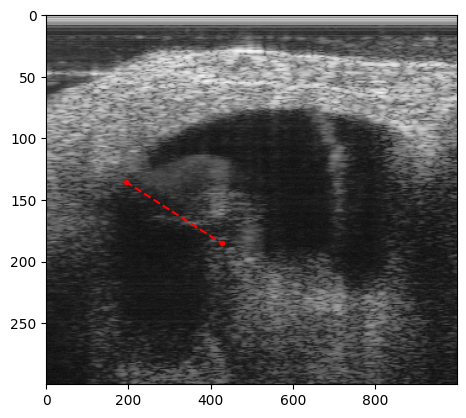

In [4]:
dd = data_dict[0] # Grab the first instance
plt.imshow(img[0, ...].numpy(), aspect=3, cmap='Greys_r')   # Show the image
boxes = dd['boxes'][0, :].detach().cpu()  # This is our annotation!
plt.plot([boxes[0], boxes[2]], [boxes[1], boxes[3]], 'r.--')
plt.show()


# Deep Learning Architecture

A deep learning model has an architecture: the structure of mathematical operations who's many parameters we will learn via training. A deep learning architecture may be trained for many different tasks. A deep learning model is an architecture with parameters trained for a specific task. U-Net is a common deep learning architecture, so is Faster RCNN. In this cell, we download a the parameters of a neural network architecture.

In [5]:
model = fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)  # Faster RCNN is our deep learning architecture.

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 93.6MB/s]


# Hardware Acceleration
The mathematic backbone of neural networks are matrix multiplications. It is perfectly appropriate to perform these operations on your computer's CPU, however significant speedups are achieved by using a graphics processing unit (GPU) as a hardware accelerator. For this demonstration, our code is run on a Google Server, and if a GPU is availabile to you, it may be used to speed up our training. Nvidia GPUs use the CUDA (Compute Unified Device Architecture) framework for deep learning acceleration. To take advantage of this speedup, we must signal to our model that we wish to use CUDA, and send the model to the graphics card memory.. CUDA is not the only hardware accelerator, Apple has the Metal framework, and AMD has ROCm.

In [6]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'  # Check to see if CUDA is available for our use!
print(f'Using device: {device}')
model = model.to(device).train()  # send our model to our hardware accelerator device
data_dict = [{k: v.to(device) for k, v in dd.items()} for dd in data_dict]  # send our training data to the hardware accelerator device

Using device: cpu


In [7]:
model = model.eval()                                                    # some models change behavior for evaluation. This one does so we must signal that it is in evaluation mode
for f in glob.glob(data_dir + 'test/*.png'):                            # load our test images
    img = torchvision.io.read_image(f) / 255                            # Our model expects the image pixels to be between 0 and 1, therefore we divide our 8bit image by 255

    out = model([img.cuda()])[0]                                        # Show the model our image and return its predictions!
    for k, v in out.items():
        print(f'{k}: {v}')

    if len(out['boxes']) == 0:
        print('Nothing detected!')
model = model.train()                                                   # signal to the model that it will be training

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

# Optimizers
Neural network optimizers, algorithms which update the model parameters, are a core part of a training pipeline. The Adam Optimization algorithm is a common choice. Each algorithm needs to know the parameters of the deep learning architecture, with additional parameters which might affect the speed of model training. In this cell, we initalize a neural network optimizer.

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)  # lr is the learning rate, which sets how much a model parameter may be updated

# Training Loop
In this next cell we train our model. To do this, we present the model an image and it makes a prediction. This prediction is compared to our "true" annotation and a quality score called a "loss metric" is calculated. Using this loss, we can update the parameters based on how each parameter affected the loss. Repeating this over and over is how a model ultimately learns from our data.

In [ ]:
for e in trange(10, desc='Training Model! '):                         # Loop over our data 100 times. A single loop is sometimes called an epoch
    for dd in data_dict:
        optimizer.zero_grad()                 # Reset our model gradients, signaling it is ready to be trained
        img = dd['image']
        loss = model([img], [dd])             # Show the model our image and data annotations
        loss = sum(l for l in loss.values())  # the model returns many loss values. These are scores of aspects of model performance, for this we sum them together
        loss.backward()                       # The backward pass is us calculating how each parameter of the model influences our loss score
        optimizer.step()                      # Stepping the optimizer updates our model!

# Model Evaluation
Once trained, we can evaluate our model on new data! Here we load a testing image and and present it to the model. As the model is well trained, it will make a reasonably confident prediction.

In [ ]:
model = model.eval()                                                    # some models change behavior for evaluation. This one does so we must signal that it is in evaluation mode
for f in glob.glob(data_dir + 'test/*.png'):                            # load our test images
    img = torchvision.io.read_image(f) / 255                            # Our model expects the image pixels to be between 0 and 1, therefore we divide our 8bit image by 255

    out = model([img.cuda()])[0]                                        # Show the model our image and return its predictions!

    plt.imshow(img[0, ...].numpy(), aspect=3, cmap='Greys_r')           # Lets show the predictions
    boxes = out['boxes'][0, :].detach().cpu()
    plt.plot([boxes[0], boxes[2]], [boxes[1], boxes[3]], 'y.--')
    plt.text(
        boxes[0], boxes[1],
        f'   {out["scores"][0].item()*100:0.2f}%', color='y')
    plt.show()